# L4: End Product Inhibition

## Overview

A common observation across biosynthetic pathways is that the end product of a pathway will inhibit the first step in its own biosynthesis. This was first observed in the biosynthesis of amino acids, specifically the production of L-isoleucine from L-threonine. In this notebook, we will use kinetic models of biochemical enzymes to explore they dynamics that arise from this type of regulation.


In [ ]:
%reset

In [ ]:
# Imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

### Introduction

The biosynthesis of L-isoleucine from L-threonine is a multi-step process involving a chain of chemical reactions with several different co-factors and side products. You can view the pathway and all of the genes involved in more detail using the [KEGG database](https://www.genome.jp/pathway/map00290). 

L-isoleucine is synthesized from L-threonine in a 5 step linear pathway. In this notebook, we will simulate a simplified version of this pathway that includes these 5 major steps. These steps are catalyzed by enzymes incoded by the genes ilvA, ilvB, ilvC, ilvD, and ilvE. This simplified pathway will not include any of the co-factors or side products of the pathway. We will use simulations of this simplified pathway to explore the dynamics that result from end product inhibition. A schematic of the pathway is given below:

$\large Thr \overset{A}{\rightleftharpoons} M_{1} \overset{B}{\rightleftharpoons} M_{2} \overset{C}{\rightleftharpoons} M_{3} \overset{D}{\rightleftharpoons} M_{4} \overset{E}{\rightleftharpoons} Ile$

Here Thr represents the amino acid L-threonine, Ile is the amino acid L-isoleucine, which is synthesized through five enzymatics steps (A-E) and 4 different intermediate molecules (M 1-4)

### Reversible Michaelis Menten

We will start by representing each enzymatic step in this process as a reversible enzyme based on the reversible Michaelis Menten equation. Unlike our previous derivation, this equation does not assume that the final product formation step is irreversible. Thus, the product concentration can influence the rate of the reaction, as reflected in the equation. 

The reversible Michaelis Menten scheme:

$\large E + S \underset{k_{-1}}{\overset{k_{1}}{\rightleftharpoons}} ES \underset{k_{-2}}{\overset{k_{2}}{\rightleftharpoons}} E + P$

The reversible Micahelis Menten rate law can be derived using the steady state assumption $\frac{d[ES]}{dt}=0$, and the relationship $E_{T} = E + ES$:

$\Large V = E_{T}*\frac{k_{1}k_{2}[S]-k_{-1}k_{-2}[P]}{k_{-1}+k_{2}+k_{1}[S]+k_{-2}[P]}$

With:

$V_{max}^{f}=E_{T}*k_{2}$, $V_{max}^{r}=E_{T}*k_{-2}$, $K_{M}^{S}=\frac{k_{-1}+k_{2}}{k_{1}}$, $K_{M}^{P}=\frac{k_{-1}+k_{2}}{k_{-2}}$

$\Large V = \frac{\frac{V_{max}^{f}}{K_{M}^{S}}*[S]-\frac{V_{max}^{r}}{K_{M}^{P}}*[P]}{1+\frac{[S]}{K_{M}^{S}}+\frac{[P]}{K_{M}^{P}}}$

The reaction rate depends on the concentration of substrate $[S]$ and product $[P]$ as well as the four parameters ($V_{max}^{f}, V_{max}^{r}, K_{M}^{S}, K_{M}^{P}$).



In [ ]:
# Plot Rate vs Substrate Concentration
V_max_f = 10
V_max_r = 1
K_M_S = 1
K_M_P = 1
P = 10
S = np.linspace(0,100,100)

V = ((V_max_f/K_M_S)*S-(V_max_r/K_M_P)*P)/(1+(S/K_M_S)+(P/K_M_P))

plt.plot(S,V)
plt.xlabel('Substrate Concentration')
plt.ylabel('Reaction Rate');

#### QUESTION 1
1. The reversible Michaelis Menten equation is a more general equation that can also capture the dynamics of the irreversible Michaelis Menten equation.
   * a. Recreate the plot above and add a curve by changing the parameters to plot the rate for the irreversible case.
   * b. Explain the changes that you made.

### Competitive Inhibition Rate Law

We will also introduce the inhibitory effect of a molecule on the kinetics of an enzyme through the competitive inhibition rate law. There are several different ways that a molecule can inhibit an enzyme that lead to slightly different rate laws (outlined in Klipp 4.1.5). Here we will use the competitive inhibition model where the inhibitor competes with the substrate to bind the enzyme (I.E. only one can bind at a time).

The reaction scheme for competitive inhibition:

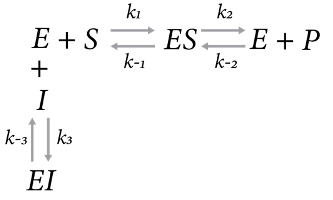

The reversible competitive inhibition rate law:

$\Large V = \frac{\frac{V_{max}^{f}}{K_{M}^{S}}*[S]-\frac{V_{max}^{r}}{K_{M}^{P}}*[P]}{1 + \frac{[S]}{K_{M}^{S}}+\frac{[P]}{K_{M}^{P}}+\frac{[I]}{K^{I}}}$

The reaction rate depends on the concetration of substrate $[S]$ and product $[P]$ as well as inhibitor $[I]$, the original four parameters ($V_{max}^{f}, V_{max}^{r}, K_{M}^{S}, K_{M}^{P}$), and a new parameter related to inhibitor binding ($K^{I}$)

Where: $K^{I} = \frac{k_{-3}}{k_{3}}$


#### QUESTION 2: 

2. Explore the shape of this equation by plotting the reaction rate $V$ as a function of inhibitor concentration $[I]$.
    * a. Use the parameters from above, setting $S=10$ and adding a new parameter K_I = 10 to plot $V$ as a function of $[I]$. Plot $[I]$ on the x-axis on a log scale.
    * b. Change the parameter $K_{I}$ to 0.1. How does this change the shape of the curve.
    * c. Provide a brief explanation for how $K_{I}$ modulates the sensitivity of the reaction rate to the concentration of inhibitor.


### Dynamic Model for End Product Inhibition

We will now put together the reversible Michaelis Menten rate law and the competitive inhibition rate law to simulate end-product inhibition dynamics with this full pathway.

We set up the equations using vectors for each parameter to save space. The parameter vectors have 5 entries, coresponding to the 5 different enzyems (A, B, C, D, and E). For example, the inhibition constant K_I_ABCDE maps the inhibition of the end product (Isoleucine) to each of the different enzymes. Each reaction uses the full competitive inhibition rate law equaiton, where the rate law can be made to represent the reversible or irreversible Michaelis Menten kinteics by changing the corresponding parameters.

In [ ]:
def EPI_dynamics(t,y,V_max_f_ABCDE,V_max_r_ABCDE,K_M_S_ABCDE,K_M_P_ABCDE,K_I_ABCDE):
    # y[0] = Thr L-threonine
    # y[1] = M1
    # y[2] = M2
    # y[3] = M3
    # y[4] = M4
    # y[5] = Ile Isoleucine
    dydt = np.zeros(6)

    I = y[5] #Isoleucine as inhibitor
    
    # enzyme rate laws
    V = np.zeros(len(y)-1)
    for i in range(len(y)-1):
        S = y[i]
        P = y[i+1]
        V[i] = ((V_max_f_ABCDE[i]/K_M_S_ABCDE[i])*S-(V_max_r_ABCDE[i]/K_M_P_ABCDE[i])*P)/(1+S/K_M_S_ABCDE[i]+P/K_M_P_ABCDE[i]+I/K_I_ABCDE[i])
        
    #dydt[0] = -V[0] #dynamic substrate
    dydt[0] = 0 #fixed substrate
    dydt[1] = V[0]-V[1]
    dydt[2] = V[1]-V[2]
    dydt[3] = V[2]-V[3]
    dydt[4] = V[3]-V[4]
    dydt[5] = V[4]

    return dydt

In [ ]:
# Initial Conditions
y0 = [10,0,0,0,0,0]
# time span
t = np.linspace(0,10,1000)
tspan = [t[0],t[-1]]
V_max_f_ABCDE = [10,10,10,10,10]
V_max_r_ABCDE = [5,5,5,5,5]
K_M_S_ABCDE = [1,1,1,1,1]
K_M_P_ABCDE = [1,1,1,1,1]
K_I_ABCDE = [100,100,100,100,100]
ode_sol = solve_ivp(lambda t,y:EPI_dynamics(t,y,V_max_f_ABCDE,V_max_r_ABCDE,K_M_S_ABCDE,K_M_P_ABCDE,K_I_ABCDE),tspan,y0,t_eval=t)

In [ ]:
plt.plot(t,ode_sol.y[0],'r')
plt.plot(t,ode_sol.y[1],'orange')
plt.plot(t,ode_sol.y[2],'y')
plt.plot(t,ode_sol.y[3],'g')
plt.plot(t,ode_sol.y[4],'b')
plt.plot(t,ode_sol.y[5],'k')

plt.xlabel('time [s]')
plt.ylabel('concentration [mM]')
plt.legend(['Thr','M1','M2','M3','M4','Ile']);


#### QUESTION 3:
3. The system is currently set up such that there is no inhibition (all inhibition constant values are very high). Thus, there is uninhibited production of isoleucine. Change the simulation such that the system displays end product inhibition by changing the inhibition constant of the first reaction.
    * a. Include a plot of the dynamics with end product inhibition.
    * b. Explain how you change the inhibition constant and how the dynamics have changed.

#### QUESTION 4:
4. In biology it is typically found that the end product inhibits the first reaction in the biosynthetic pathway. Change the simulation so that the end product inhibits the last enzyme in the pathway.
   * a. Plot the dynamics for this scenario.
   * b. Provide a brief discussion of why biological systems might prefer to inhibit the first step in the pathway rather than later steps.

#### QUESTION 5:
5. In the Umbarger [1956] paper the statement is made that because the first step in the reaction pathway is irreversible, it must be the step that is inhibited. Change the parameters such that this first step is made irreversible.
   * a. Provide a plot of this new system where the first step is also inhibited.
   * b. Provide a plot of this new system where some other step is inhibited.
   * c. Explain how the first step being irreversible necessitates that this step be inhibited to prevent run away Isoleucine production.

### BONUS
In the Umbarger [1956] paper the observation was made that the presence of L-isoleucine prevented the depletion of L-threonine. We can explore this observation by adding dynamics to the L-threonine concentration and testing the impact of adding an initial amount of L-isoleucine under different regulatory patterns.


In [ ]:
# Pathway dynamics with dynamic substrate
def EPI_dynamics_2(t,y,V_max_f_ABCDE,V_max_r_ABCDE,K_M_S_ABCDE,K_M_P_ABCDE,K_I_ABCDE):
    # y[0] = Thr L-threonine
    # y[1] = M1
    # y[2] = M2
    # y[3] = M3
    # y[4] = M4
    # y[5] = Ile Isoleucine
    dydt = np.zeros(6)

    I = y[5] #Isoleucine as inhibitor
    
    # enzye rate laws
    V = np.zeros(len(y)-1)
    for i in range(len(y)-1):
        S = y[i]
        P = y[i+1]
        V[i] = ((V_max_f_ABCDE[i]/K_M_S_ABCDE[i])*S-(V_max_r_ABCDE[i]/K_M_P_ABCDE[i])*P)/(1+S/K_M_S_ABCDE[i]+P/K_M_P_ABCDE[i]+I/K_I_ABCDE[i])
        
    dydt[0] = -V[0] #dynamic substrate
    #dydt[0] = 0 #fixed substrate
    dydt[1] = V[0]-V[1]
    dydt[2] = V[1]-V[2]
    dydt[3] = V[2]-V[3]
    dydt[4] = V[3]-V[4]
    dydt[5] = V[4]

    return dydt

In [ ]:
fig,axs = plt.subplots(2,3,figsize=(14, 8))
# with out end product inhibition
# Initial Conditions
y0 = [10,0,0,0,0,0]
# time span
t = np.linspace(0,10,1000)
tspan = [t[0],t[-1]]
V_max_f_ABCDE = [10,10,10,10,10]
V_max_r_ABCDE = [5,5,5,5,5]
K_M_S_ABCDE = [1,1,1,1,1]
K_M_P_ABCDE = [1,1,1,1,1]
K_I_ABCDE = [100,100,100,100,100]
ode_sol = solve_ivp(lambda t,y:EPI_dynamics_2(t,y,V_max_f_ABCDE,V_max_r_ABCDE,K_M_S_ABCDE,K_M_P_ABCDE,K_I_ABCDE),tspan,y0,t_eval=t)
axs[0,0].plot(t,ode_sol.y[0],'r')
axs[0,0].plot(t,ode_sol.y[1],'orange')
axs[0,0].plot(t,ode_sol.y[2],'y')
axs[0,0].plot(t,ode_sol.y[3],'g')
axs[0,0].plot(t,ode_sol.y[4],'b')
axs[0,0].plot(t,ode_sol.y[5],'k')
axs[0,0].set_xlabel('time [s]')
axs[0,0].set_ylabel('concentration [mM]')
axs[0,0].legend(['Thr','M1','M2','M3','M4','Ile']);
axs[0,0].set_title('No Inhibition')

# first step inhibition
# Initial Conditions
y0 = [10,0,0,0,0,0]
# time span
t = np.linspace(0,10,1000)
tspan = [t[0],t[-1]]
V_max_f_ABCDE = [10,10,10,10,10]
V_max_r_ABCDE = [5,5,5,5,5]
K_M_S_ABCDE = [1,1,1,1,1]
K_M_P_ABCDE = [1,1,1,1,1]
K_I_ABCDE = [0.01,100,100,100,100]
ode_sol = solve_ivp(lambda t,y:EPI_dynamics_2(t,y,V_max_f_ABCDE,V_max_r_ABCDE,K_M_S_ABCDE,K_M_P_ABCDE,K_I_ABCDE),tspan,y0,t_eval=t)
axs[0,1].plot(t,ode_sol.y[0],'r')
axs[0,1].plot(t,ode_sol.y[1],'orange')
axs[0,1].plot(t,ode_sol.y[2],'y')
axs[0,1].plot(t,ode_sol.y[3],'g')
axs[0,1].plot(t,ode_sol.y[4],'b')
axs[0,1].plot(t,ode_sol.y[5],'k')
axs[0,1].set_xlabel('time [s]')
axs[0,1].set_ylabel('concentration [mM]')
axs[0,1].legend(['Thr','M1','M2','M3','M4','Ile']);
axs[0,1].set_title('First Step Inhibition');
# last step inhibition
# Initial Conditions
y0 = [10,0,0,0,0,0]
# time span
t = np.linspace(0,10,1000)
tspan = [t[0],t[-1]]
V_max_f_ABCDE = [10,10,10,10,10]
V_max_r_ABCDE = [5,5,5,5,5]
K_M_S_ABCDE = [1,1,1,1,1]
K_M_P_ABCDE = [1,1,1,1,1]
K_I_ABCDE = [100,100,100,100,0.01]
ode_sol = solve_ivp(lambda t,y:EPI_dynamics_2(t,y,V_max_f_ABCDE,V_max_r_ABCDE,K_M_S_ABCDE,K_M_P_ABCDE,K_I_ABCDE),tspan,y0,t_eval=t)
axs[0,2].plot(t,ode_sol.y[0],'r')
axs[0,2].plot(t,ode_sol.y[1],'orange')
axs[0,2].plot(t,ode_sol.y[2],'y')
axs[0,2].plot(t,ode_sol.y[3],'g')
axs[0,2].plot(t,ode_sol.y[4],'b')
axs[0,2].plot(t,ode_sol.y[5],'k')
axs[0,2].set_xlabel('time [s]')
axs[0,2].set_ylabel('concentration [mM]')
axs[0,2].legend(['Thr','M1','M2','M3','M4','Ile']);
axs[0,2].set_title('Last Step Inhibition');


# with out end product inhibition
# Initial Conditions
y0 = [10,0,0,0,0,10]
# time span
t = np.linspace(0,10,1000)
tspan = [t[0],t[-1]]
V_max_f_ABCDE = [10,10,10,10,10]
V_max_r_ABCDE = [5,5,5,5,5]
K_M_S_ABCDE = [1,1,1,1,1]
K_M_P_ABCDE = [1,1,1,1,1]
K_I_ABCDE = [100,100,100,100,100]
ode_sol = solve_ivp(lambda t,y:EPI_dynamics_2(t,y,V_max_f_ABCDE,V_max_r_ABCDE,K_M_S_ABCDE,K_M_P_ABCDE,K_I_ABCDE),tspan,y0,t_eval=t)
axs[1,0].plot(t,ode_sol.y[0],'r')
axs[1,0].plot(t,ode_sol.y[1],'orange')
axs[1,0].plot(t,ode_sol.y[2],'y')
axs[1,0].plot(t,ode_sol.y[3],'g')
axs[1,0].plot(t,ode_sol.y[4],'b')
axs[1,0].plot(t,ode_sol.y[5],'k')
axs[1,0].set_xlabel('time [s]')
axs[1,0].set_ylabel('concentration [mM]')
axs[1,0].legend(['Thr','M1','M2','M3','M4','Ile']);
axs[1,0].set_title('No Inhibition')

# first step inhibition
# Initial Conditions
y0 = [10,0,0,0,0,10]
# time span
t = np.linspace(0,10,1000)
tspan = [t[0],t[-1]]
V_max_f_ABCDE = [10,10,10,10,10]
V_max_r_ABCDE = [5,5,5,5,5]
K_M_S_ABCDE = [1,1,1,1,1]
K_M_P_ABCDE = [1,1,1,1,1]
K_I_ABCDE = [0.01,100,100,100,100]
ode_sol = solve_ivp(lambda t,y:EPI_dynamics_2(t,y,V_max_f_ABCDE,V_max_r_ABCDE,K_M_S_ABCDE,K_M_P_ABCDE,K_I_ABCDE),tspan,y0,t_eval=t)
axs[1,1].plot(t,ode_sol.y[0],'r')
axs[1,1].plot(t,ode_sol.y[1],'orange')
axs[1,1].plot(t,ode_sol.y[2],'y')
axs[1,1].plot(t,ode_sol.y[3],'g')
axs[1,1].plot(t,ode_sol.y[4],'b')
axs[1,1].plot(t,ode_sol.y[5],'k')
axs[1,1].set_xlabel('time [s]')
axs[1,1].set_ylabel('concentration [mM]')
axs[1,1].legend(['Thr','M1','M2','M3','M4','Ile']);
axs[1,1].set_title('First Step Inhibition');
# last step inhibition
# Initial Conditions
y0 = [10,0,0,0,0,10]
# time span
t = np.linspace(0,10,1000)
tspan = [t[0],t[-1]]
V_max_f_ABCDE = [10,10,10,10,10]
V_max_r_ABCDE = [5,5,5,5,5]
K_M_S_ABCDE = [1,1,1,1,1]
K_M_P_ABCDE = [1,1,1,1,1]
K_I_ABCDE = [100,100,100,100,0.01]
ode_sol = solve_ivp(lambda t,y:EPI_dynamics_2(t,y,V_max_f_ABCDE,V_max_r_ABCDE,K_M_S_ABCDE,K_M_P_ABCDE,K_I_ABCDE),tspan,y0,t_eval=t)
axs[1,2].plot(t,ode_sol.y[0],'r')
axs[1,2].plot(t,ode_sol.y[1],'orange')
axs[1,2].plot(t,ode_sol.y[2],'y')
axs[1,2].plot(t,ode_sol.y[3],'g')
axs[1,2].plot(t,ode_sol.y[4],'b')
axs[1,2].plot(t,ode_sol.y[5],'k')
axs[1,2].set_xlabel('time [s]')
axs[1,2].set_ylabel('concentration [mM]')
axs[1,2].legend(['Thr','M1','M2','M3','M4','Ile']);
axs[1,2].set_title('Last Step Inhibition');